## Dogs vs Cats Redux
Wayne H Nixalo

FAI 1 - Practical Deep Learning I - Lesson 1/2 - Image Recognition

Code-Along with [dogs_cats_redux.ipynb](https://github.com/fastai/courses/blob/master/deeplearning1/nbs/dogs_cats_redux.ipynb)


In this tutorial, you will learn how generate and submit predictions to a Kaggle competiton
[Dogs vs. Cats Redux: Kernels Edition](https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition)

Directory structure:
```
utils/
    vgg16.py
    utils.py
lesson1/
    WNx_lesson1_codealong_cats_vs_dogs_redux_ipynb
    data/
        redux/
            train/
                cat.437.jpg
                dog.9924.jpg
                ....
            test/
                231.jpg
                325.jpg
                ....
```
You can download the data files from the competition page [here](https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/data) or you can download them from the command line using the [Kaggle CLI](https://github.com/floydwch/kaggle-cli).

Launch notebook inside lesson1 directory
```
cd lesson1
jupyter notebook
```

In [1]:
#Verify we're in the lesson1 directory
%pwd

u'/Users/WayNoxchi/Deshar/CodeDeshar/FAI/lesson1'

In [2]:
# Create references to important directories we'll use over and over
import os, sys
current_dir = os.getcwd()
LESSON_HOME_DIR = current_dir
# %mkdir data # make it if it isn't there
DATA_HOME_DIR = current_dir+'/data'

For some reason, my current working directory wasn't the system path. Instead it was a bunch of references to my Miniconda3 directory. Maybe this is bc of how I installed it and os.path and sys.path read from a global path file, I don't know.

However, if add the current working directory + '../utils' to my sys.path, I'm able to import modules living in the utils folder in the parent directory. I think J.Howard was doing this but my setup is different. Maybe. 

In [3]:
# Allow relative imports to directories above lesson1/
# sys.path.insert(1, os.path.join(sys.path[0], '..'))
sys.path.insert(1, os.path.join(LESSON_HOME_DIR, '../utils'))

# import modules
from utils import *
from vgg16 import Vgg16

# Instatiate plotting tool
# In Jupyter notebooks, you will need to run this command before doing any plotting
%matplotlib inline

Using Theano backend.


In [4]:
# # Me playing w/ sys.path & os.path to get utils/ loaded above.
# sys.path.insert(1,'/Users/WayNoxchi/Deshar/CodeDeshar/FAI/utils')
# print(sys.path[1])
# help(os.path.join)

## Action Plan
1. Create Validation and Sample sets
2. Rearrange image files into their respective directories
3. Finetune and Train model
4. Generate predictions
5. Validate predictions
6. Submit predictions to Kaggle

## Create Validation set and Sample

In [ ]:
# Create directories
%cd $DATA_HOME_DIR
%mkdir valid
%mkdir results
%mkdir -p sample/train
%mkdir -p sample/test
%mkdir -p sample/valid
%mkdir -p sample/results
%mkdir -p test/unknown

Go into the data/train directory. Move a shuffled set of images to data/valid. Copy a shuffled set of images from data/train to data/sample/train. From data/valid copy a shuffled set of images to /data/sample/valid.

Helper function copyfile(..) from shutil will help us with the copying. Moving is done via  os.rename(..)

On my MacBook I'm using a full dataset of 1000 imgs: 400 test, 600 train. From that: 50 for validation, 100 as a sample. On my Asus it'll be the full 12.5k train, 25k test set.

In [5]:
%cd $DATA_HOME_DIR/train

/Users/WayNoxchi/Deshar/CodeDeshar/FAI/lesson1/data/train


In [ ]:
g = glob('*.jpg')
shuf = np.random.permutation(g)
# move validation set from data/train --> data/valid
for i in range(50): os.rename(shuf[i], DATA_HOME_DIR + '/valid/' + shuf[i])

In [6]:
from shutil import copyfile

In [ ]:
g = glob('*.jpg')
shuf = np.random.permutation(g)
for i in range(100): copyfile(shuf[i], DATA_HOME_DIR + '/sample/train/' + shuf[i])

In [7]:
%cd $DATA_HOME_DIR/valid

/Users/WayNoxchi/Deshar/CodeDeshar/FAI/lesson1/data/valid


In [ ]:
g = glob('*.jpg')
shuf = np.random.permutation(g)
for i in range(10): copyfile(shuf[i], DATA_HOME_DIR + '/sample/valid/' + shuf[i])

## Rearrange image files into their respective directories

In [ ]:
# Divide cat/dog images into separate directories

# gotta do this for both sample folders, and train, and valid
%cd  $DATA_HOME_DIR/sample/train
%mkdir cats
%mkdir dogs
%mv cat.*.jpg cats/
%mv dog.*.jpg dogs/

%cd $DATA_HOME_DIR/sample/valid
%mkdir cats
%mkdir dogs
%mv cat.*.jpg cats/
%mv dog.*.jpg dogs/

%cd $DATA_HOME_DIR/train
%mkdir cats
%mkdir dogs
%mv cat.*.jpg cats/
%mv dog.*.jpg dogs/

%cd $DATA_HOME_DIR/valid
%mkdir cats
%mkdir dogs
%mv cat.*.jpg cats/
%mv dog.*.jpg dogs/

In [ ]:
# Create single 'unkown' class for test set
%cd $DATA_HOME_DIR/test
%mv *.jpg unknown/

## Finetuning and Training

In [8]:
%cd $DATA_HOME_DIR

# Set path to sample/ path if desired; otherwise just + '/'
path = DATA_HOME_DIR + '/sample/'
test_path = DATA_HOME_DIR + '/test/' # we're using all the test data
results_path = DATA_HOME_DIR + '/results/'
train_path = DATA_HOME_DIR + '/train/'
valid_path = DATA_HOME_DIR + '/valid/'

/Users/WayNoxchi/Deshar/CodeDeshar/FAI/lesson1/data


In [9]:
# from theano.ifelse import ifelse

In [10]:
# import Vgg16 helper class 
# NOTE: self.FILE_PATH may be hard coded as 'http://www.platform.ai/models/' J.Howard updated 
#       this to 'http://files.fast.ai/models/' so update vgg16 & vgg16bn
vgg = Vgg16()

In [11]:
# Set constants. You can experiment with no_of_epochs to improve the model
batch_size=64
no_of_epochs=3

In [12]:
# Finetune the model.
# validation doesn't need backpropagation, so uses less memory, so can use larger batches
batches = vgg.get_batches(train_path, batch_size=batch_size)
val_batches = vgg.get_batches(valid_path, batch_size=batch_size*2)
vgg.finetune(batches)

# Note sure if we set this for all fits
vgg.model.optimizer.lr = 0.01

Found 352 images belonging to 2 classes.
Found 50 images belonging to 2 classes.


We're also saving our weights after each epoch.

In [13]:
# NOTE we are passing in the validation dataset to the fit() method
# Foreach epoch we test our model against the validation set
latest_weights_filename = None
for epoch in range(no_of_epochs):
    print "Running epoch %d" % epoch
    vgg.fit(batches, val_batches, nb_epoch=1)
    latest_weights_filename = 'ft%d.h5' % epoch
    vgg.model.save_weights(results_path + latest_weights_filename)
print "Completed %s fit operations" % no_of_epochs

# may want to start with a higher η, then lower to 0.01 after 1st epoch.

Running epoch 0
Epoch 1/1
352/352 [==============================] - 159s - loss: 0.6653 - acc: 0.8523 - val_loss: 0.1652 - val_acc: 0.9800
Running epoch 1
Epoch 1/1
352/352 [==============================] - 210s - loss: 0.2484 - acc: 0.9744 - val_loss: 0.2784 - val_acc: 0.9600
Running epoch 2
Epoch 1/1
352/352 [==============================] - 191s - loss: 0.2277 - acc: 0.9830 - val_loss: 0.1813 - val_acc: 0.9600
Completed 3 fit operations


## Generate Predictions

Using the new model to make predictions on the test dataset

In [14]:
batches, preds = vgg.test(test_path, batch_size=batch_size*2)

Found 600 images belonging to 1 classes.


In [17]:
# For every image, vgg.test() generates two probabilities based on how we've ordered the 
# cats/dogs directories. Looks like col 1 is cats, col 2 is dogs.
print preds[:5]

filenames = batches.filenames
print filenames[:5]

[[  1.6267e-22   1.0000e+00]
 [  1.0000e+00   8.1177e-42]
 [  1.0000e+00   2.3927e-23]
 [  1.0000e+00   6.5402e-25]
 [  5.5020e-24   1.0000e+00]]
['unknown/1.jpg', 'unknown/10.jpg', 'unknown/100.jpg', 'unknown/101.jpg', 'unknown/102.jpg']


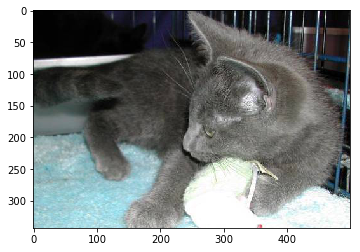

In [51]:
# You can verify the column ordering by viewing some images
from PIL import Image
from matplotlib.pyplot import imshow
imshow(Image.open(test_path + filenames[2]))
# print test_path + filenames[2]

NOTE: I wasn't able to get PIL.Image.open(•) to display an image in the notebook. Instead it returns the image object: 

```
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=499x343 at 0x12035B8C0>
```

If I run .show() after the call, PIL opens the image in my system's image viewer. I got around this by importing matplotlib.pyplot.imshow, then calling imshow(•) on the image object:

```
imshow(Image.open(test_path + filenames[2]))
```
And this displays the image, albeit as a plot.

In [52]:
# Save our test results arrays so we can use them again later
save_array(results_path + 'test_preds.dat', preds)
save_array(results_path + 'filenames.dat', filenames)

## Validate Predictions
Keras' *fit()* function conveniently shows us the value of the loss function, and the accuracy, after every epoch (ea. full run through all training examples). The most important metrics for us to look at are for the validation set, since we want to check for over-fitting.

- **Tip**: with our first model we should try to overfit before we start worrying about how to reduce over-fitting - there's no point even thinking about regularization, data augmentation, etc if you're still under-fitting! (We'll be looking at these techniques shortly).

As well as looking at the overall metrics, it's also a good idea to look at examples of each of:
1. A few correct labels at random
2. A few incorrect labels at random
3. The most correct labels of each class (ie those with highest probability that are correct)
4. The most incorrect labels of each class (ie those with highest probability that are incorrect)
5. The most incertain labels (ie those with probability closest to 0.5).

Let's see what we can learn from these examples. (In general, this is a particularly useful technique for debugging problems in the model. However, since this model is so simple, there may not be too much to learn at this stage.)

Calculate prediction on validation set, so we can find corect and incorrect examples:

In [53]:
vgg.model.load_weights(results_path + latest_weights_filename)

In [54]:
val_batches, probs = vgg.test(valid_path, batch_size = batch_size)

Found 50 images belonging to 2 classes.


In [55]:
filenames = val_batches.filenames
expected_labels = val_batches.classes # 0 / 1

# Round our predictions to 0/1 to generate labels
our_predictions = probs[:,0]
our_labels = np.round(1 - our_predictions)

In [56]:
from keras.preprocessing import image

# Helper function to plot images by index in the validation set
# Plots is a helper function in utils.py
def plots_idx(idx, titles=None):
    plots([image.load_img(valid_path + filenames[i]) for i in idx], titles=titles)

# Number of images to view for each visualization task
n_view = 4

Found 48 correct labels


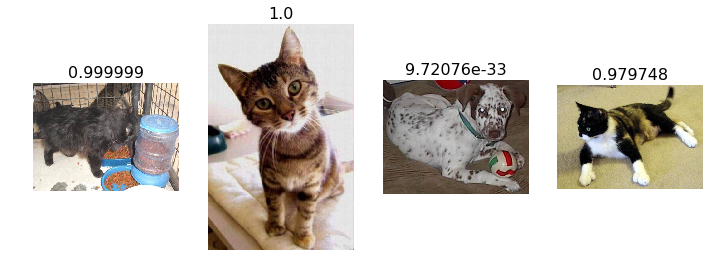

In [58]:
# 1. A few correct labels at random
correct = np.where(our_labels==expected_labels)[0]
print "Found %d correct labels" % len(correct)
idx = permutation(correct)[:n_view]
plots_idx(idx, our_predictions[idx])

Found 2 incorrect labels


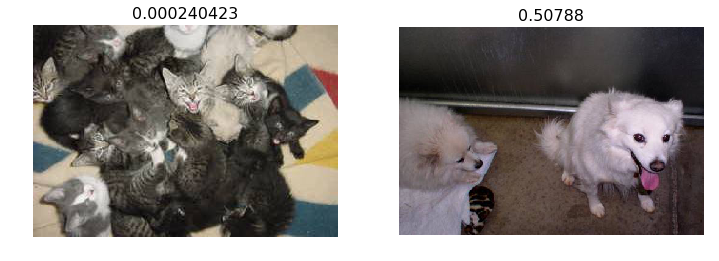

In [60]:
# 2. A few incorrect labels at random
incorrect = np.where(our_labels!=expected_labels)[0]
print "Found %d incorrect labels" % len(incorrect)
idx = permutation(incorrect)[:n_view]
plots_idx(idx, our_predictions[idx])

Found 26 confident correct cats labels


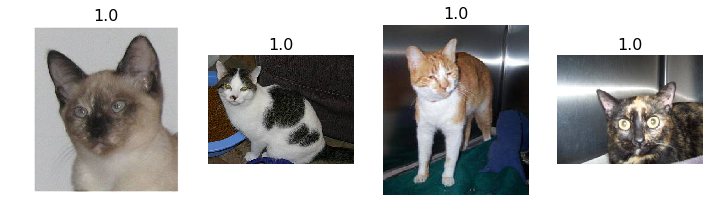

In [63]:
# 3a. The images we're most confident were cats, and are actually cats
correct_cats = np.where((our_labels==0) & (our_labels==expected_labels))[0]
print "Found %d confident correct cats labels" % len(correct_cats)
most_correct_cats = np.argsort(our_predictions[correct_cats])[::-1][:n_view]
plots_idx(correct_cats[most_correct_cats], our_predictions[correct_cats][most_correct_cats])

Found 22 confident correct dogs labels


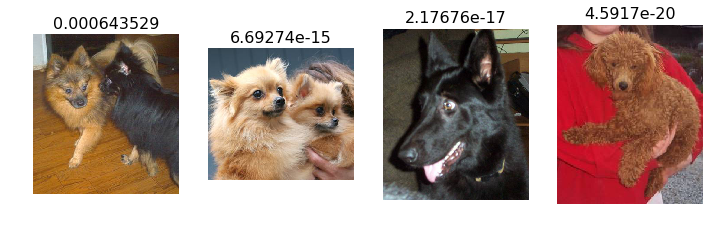

In [65]:
# 3b. The images we're most confident were dogs, and are actually dogs
correct_dogs = np.where((our_labels==1) & (our_labels==expected_labels))[0]
print "Found %d confident correct dogs labels" % len(correct_dogs)
most_correct_dogs = np.argsort(our_predictions[correct_dogs])[::-1][:n_view]
plots_idx(correct_dogs[most_correct_dogs], our_predictions[correct_dogs][most_correct_dogs])

Found 1 incorrect cats labels


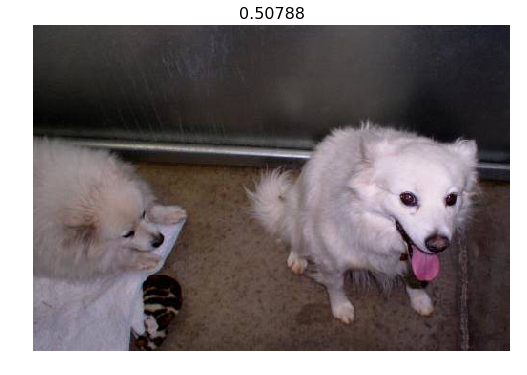

In [66]:
# 4a. The images we're most confident were cats, but are actually dogs
incorrect_cats = np.where((our_labels==0) & (our_labels!=expected_labels))[0]
print "Found %d incorrect cats labels" % len(incorrect_cats)
if len(incorrect_cats):
    most_incorrect_cats = np.argsort(our_predictions[incorrect_cats])[::-1][:n_view]
    plots_idx(incorrect_cats[most_incorrect_cats], our_predictions[incorrect_cats][most_incorrect_cats])

Found 1 incorrect dogs labels


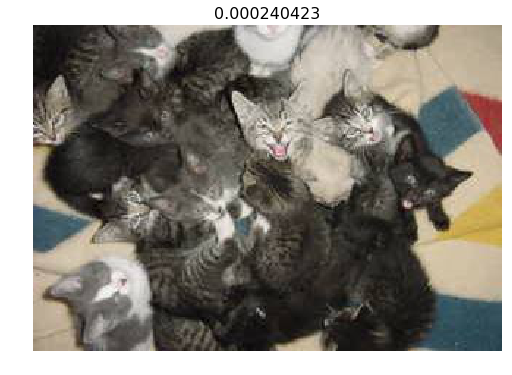

In [67]:
# 4b. The image we're most confident were dogs, but are actually cats
incorrect_dogs = np.where((our_labels==1) & (our_labels!=expected_labels))[0]
print "Found %d incorrect dogs labels" % len(incorrect_dogs)
if len(incorrect_dogs):
    most_incorrect_dogs = np.argsort(our_predictions[incorrect_dogs])[::-1][:n_view]
    plots_idx(incorrect_dogs[most_incorrect_dogs], our_predictions[incorrect_dogs][most_incorrect_dogs])

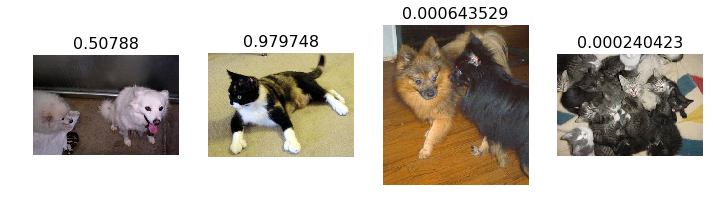

In [68]:
# 5. The most uncertain labels (ie those with probability closest to 0.5)
most_uncertain = np.argsort(np.abs(our_predictions - 0.5))
plots_idx(most_uncertain[:n_view], our_predictions[most_uncertain])

Perhaps the most common way to analyze the result of a classification model is to use a [confusion matrix](http://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/). Scikit-learn has a convenient function we can use for this purpose:

In [69]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(expected_labels, our_labels)

We can just pritn out the confusion matrix, or we can show a graphical view (which is mainly useful for dependents with a larger number of categories).

[[26  1]
 [ 1 22]]


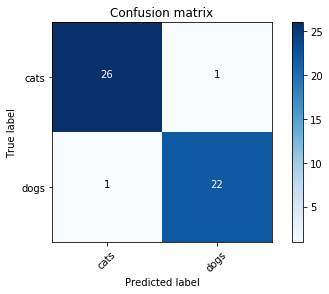

In [70]:
plot_confusion_matrix(cm, val_batches.class_indices)

## Submit Predictions to Kaggle:
Here's the format Kaggle requires for new submissions:
```
imageId,isDog
1242, .3984
3947, .1000
4539, .9082
2345, .0000
```
Kaggle wants the imageId followed by the probability of the image being a dog. Kaggle uses a metric called [Log Loss](http://wiki.fast.ai/index.php/Log_Loss) to evaluate your submission.

In [71]:
# Load our test predictions from file
preds = load_array(results_path + 'test_preds.dat')
filenames = load_array(results_path + 'filenames.dat')

In [76]:
# Grab the dog prediction column
isdog = preds[:,1]
print "Raw Predictions: " + str(isdog[:5])
print "Mid Predictions: " + str(isdog[(isdog < 0.6) & (isdog > 0.4)])
print "Edge Predictions: " + str(isdog[(isdog == 1) | (isdog == 0)][:5])

Raw Predictions: [  1.0000e+00   8.1177e-42   2.3927e-23   6.5402e-25   1.0000e+00]
Mid Predictions: [ 0.4122]
Edge Predictions: [ 1.  1.  1.  1.  1.]


[Log Loss](http://wiki.fast.ai/index.php/Log_Loss) doesn't support probability values of 0 or 1 -- they're undeifined (and we hav emany). Fortunately, Kaggle helps us by offsetting our 0s and 1s by a very small value. So if we upload our submission now, we'll have lots of 0.999999999 and 0.000000001 values. This seems good, right?

Not so. There's an additional twist due to how log loss is calculated -- log loss rewards predictions that are confident and correct (p=.9999,label=1), but it punishes predictions that are confident and wrong far more (p=.0001,label=1). See visualization below.

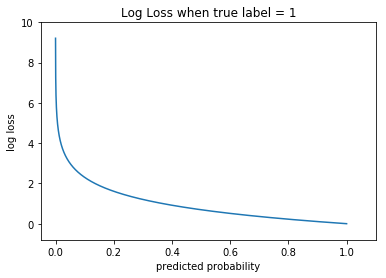

In [146]:
# Visualize Log Loss when True value = 1
# y-axis is log loss, x-axis is probability that label = 1
# As you can see Log Loss increases rapidly as we approach 0
# But increases slowly as our predicted probability gets closer to 1
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import log_loss
x = [i*.0001 for i in xrange(1,10000)]
y = [log_loss([1],[[i*.0001,1-(i*.0001)]],eps=1e-15,labels=[0,-1]) for i in xrange(1,10000,1)]

plt.plot(x, y)
plt.axis([-.05, 1.1, -.8, 10])
plt.title("Log Loss when true label = 1")
plt.xlabel("predicted probability")
plt.ylabel("log loss")

plt.show()

The method above was causing a ValueError because sklearn.metrics.logloss(•) wants to 
know its labels (labels wasn't explicitly defined). This code will make the correct plot:
```
http://forums.fast.ai/t/sklearn-log-loss-error/839/6?u=borz
```
If I input y_true = [0] and labels=[0,1] OR y_true = [1] and labels=[0,-1] you get
the correct plot. y_true = [1] and labels=[0,1] generates a reversed plot..

In [142]:
# So to play it safe, we use a sneaky trick to round down our edge predictions
# Swap all ones with .95 and all zeros with .05
isdog = isdog.clip(min=0.05, max=0.95)

In [145]:
# Extract imageIds from the filenames in our test/unknown directory
filenames = batches.filenames
ids = np.array([int(f[8:f.find('.')]) for f in filenames]) # 'unknown/' is 8 chars long

Here we join the two columns into an array of [imageId, isDog]

In [147]:
subm = np.stack([ids,isdog],axis=1)
subm[:5]

array([[  1.0000e+00,   9.5000e-01],
       [  1.0000e+01,   5.0000e-02],
       [  1.0000e+02,   5.0000e-02],
       [  1.0100e+02,   5.0000e-02],
       [  1.0200e+02,   9.5000e-01]])

In [148]:
%cd $DATA_HOME_DIR
submission_file_name = 'submission1.csv'
np.savetxt(submission_file_name, subm, fmt='%d,%.5f', header='id,label', comments='')

/Users/WayNoxchi/Deshar/CodeDeshar/FAI/lesson1/data


In [153]:
from IPython.display import FileLink
%cd $LESSON_HOME_DIR
FileLink('data/' + submission_file_name)

/Users/WayNoxchi/Deshar/CodeDeshar/FAI/lesson1


/Users/WayNoxchi/Deshar/CodeDeshar/FAI/lesson1/data/submission1.csv

Some helpful [links](http://nbviewer.jupyter.org/github/ipython/ipython/blob/1.x/examples/notebooks/Part%205%20-%20Rich%20Display%20System.ipynb#Links-to-local-files) for IPython.display

-- Wayne H Nixalo 05 May 2017